## CS6650 Homework 2 (Holi 2023 Semester)

---

Name: `Ashwin A Nayar`

Roll No: `NA19B001`

Email: `na19b001@smail.iitm.ac.in`

---


### Preliminary Analysis of PPG Sensor Signals

Refer to the PPG sensor logs shared in the class lecture wiki. Your task is to perform some preliminary analysis on the same dataset. It consists of three columns, a UNIX epoch timestamp in milliseconds, photodiode responses (digitized) for the IR led and the Red led, respectively. For the rest of the document, we will refer to these digital signals as IR and RED.

Create a directory, `<Your_Roll>_CS6650H23`. Place this notebook and the dataset file in that directory. Now you will perform the following tasks:

1. [Visualize the data (5 points)](#task1)
2. [Peak detection (15 points)](#task2)
3. [Frequency domain analysis (32 points)](#task3)
4. [Spectrograms (20 points)](#task4)
5. [Quantization of sensor data (28 points)](#task5)

Please keep in mind,

- Clean and well-documented code is expected. Your code should be organized in a clear and readable manner, with each task separated into its own section of the notebook.

- There will be no separate PDF report required this time. Instead, provide a detailed but to-the-point discussion in the observation section for each task. The observation section (in Markdown, Refer to [Markdown-Cheatsheet](https://github.com/lifeparticle/Markdown-Cheatsheet)) includes a clear and concise description of the task, the approach used to solve it, assumptions, and inferences.

- Any extraneous information that does not directly address the question should be removed before submission. This will help to ensure that the answer is clear and easy to follow.

Failure to follow these practices will result in a penalty.

**Deadline: $2^{nd}$, April, 2023**

#### Submission Instructions

- Compress the top-level directory (ZIP format) containing this notebook with your code and the data used for the assignment. (do not remove the outputs from the notebook cells)

- **You MUST refrain from consulting your homework code with others**. Any plagiarism found in your code (or somebody who is referring to your code) will result in zero credits in this assignment.

- Submissions after the deadline will not be entertained.


### Task 1: Visualize the data [5 points] <a id='task1'></a>

Read the dataset into memory.

1. Plot the IR and RED signals in the time domain - approx length of samples ~32.14 seconds.
2. What is the sample rate at which the data has been collected? Is it uniform? If not, what is the standard deviation?


Total sampling duration: 32139 ms
Estimated sample rate: 16.07 Hz
Sample rate std. dev: 1.33 Hz


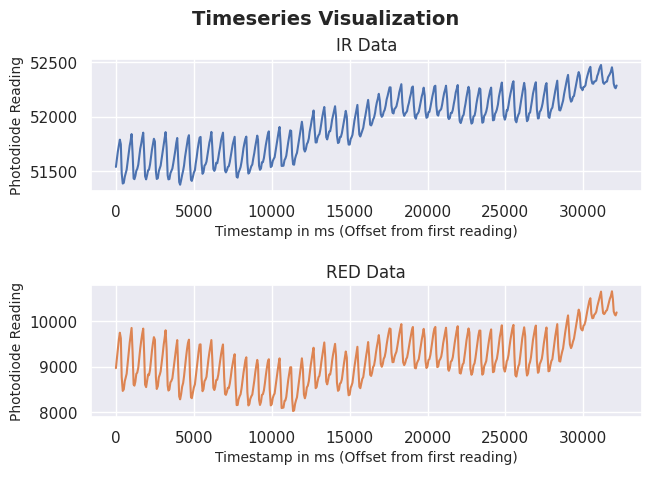

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, detrend
from numpy.lib.stride_tricks import sliding_window_view
import seaborn as sns

sns.set_theme()
cmap = sns.color_palette()

PPG_LOG_FILE = "data/ppg_log.csv"
ID_TIME, ID_IR, ID_RED = 0, 1, 2  # Column indices of data

# Read PPG log
ppg_data = np.genfromtxt(PPG_LOG_FILE)

# We'll save the timestamps in memory as offsets from the first data timestamp.
# We save this constant if required to compute the absolute timestamp in future.
# Using offsets will help clean up plot labels and data visualization and won't affect
# most of the calculations henceforth
SAMPLE_TIME_BEGIN = ppg_data[0, ID_TIME]
ppg_data[:, ID_TIME] -= SAMPLE_TIME_BEGIN

# Calculate total sampling duration
sampling_duration = int(ppg_data[-1, ID_TIME] - ppg_data[0, ID_TIME])
# Frequency of sampling is the difference in consecutive timestamps.
# Since timestamps are in milliseconds we scale by 1000 to compute
# instantaneous sampling frequency in Hz.
sample_rate = 1000 / np.diff(ppg_data[:, ID_TIME])
# Sample rate may not be uniform, thus take mean
sample_rate_est = sample_rate.mean()  # In Hz
# Calculate std. deviation of sampling rate. If std == 0, uniform sampling.
sample_rate_std = sample_rate.std()  # In Hz

print(f"Total sampling duration: {sampling_duration} ms")
print(f"Estimated sample rate: {sample_rate_est:0.2f} Hz")
print(f"Sample rate std. dev: {sample_rate_std:0.2f} Hz")

plt.rcParams["figure.constrained_layout.use"] = True

plt.subplot(2, 1, 1)
plt.plot(ppg_data[:, ID_TIME], ppg_data[:, ID_IR], color=cmap[0])
plt.xlabel("Timestamp in ms (Offset from first reading)\n", fontsize="small")
plt.ylabel("Photodiode Reading", fontsize="small")
plt.title("IR Data")

plt.subplot(2, 1, 2)
plt.plot(ppg_data[:, ID_TIME], ppg_data[:, ID_RED], color=cmap[1])
plt.xlabel("Timestamp in ms (Offset from first reading)\n", fontsize="small")
plt.ylabel("Photodiode Reading", fontsize="small")
plt.title("RED Data")

plt.suptitle("Timeseries Visualization", fontsize=14, fontweight="bold")
plt.show()


##### Observations Task 1

Q. *What is the sample rate at which the data has been collected? Is it uniform? If not, what is the standard deviation?*
- **Approach**
    - Frequency of sampling can be calculated from the difference in consecutive timestamps by the relation $f = 1 / (t_i - t_{i-1})$. 
    - This gives us the instantaneous sampling frequency at every point and helps analyse uniformity of sampling.
    - The average sample rate was estimated to be ~ **16Hz**.
    - Non-zero standard deviation in instantaneous sampling frequency indicate non-uniform sampling.
    - Sampling rate standard deviation = **1.33Hz**.
- **Inference**
    - Non-uniformity in sampling is expected as perfect sampling is almost never achievable practically.


### Task 2: Peak detection [5 + 10 = 15 points] <a id='task2'></a>

Your task is to detect peaks in the time domain data using the `scipy.signal.find_peaks` method on both IR and RED signals.

1. Plot the peak locations for the signals. Do the peak indices between the two signals match?
2. Calculate the BPM using a sliding window of size 4 seconds. Plot BPM versus time.


Peak indices diff. range: (0, 1)
Peak indices diff. sparsity: 0.96


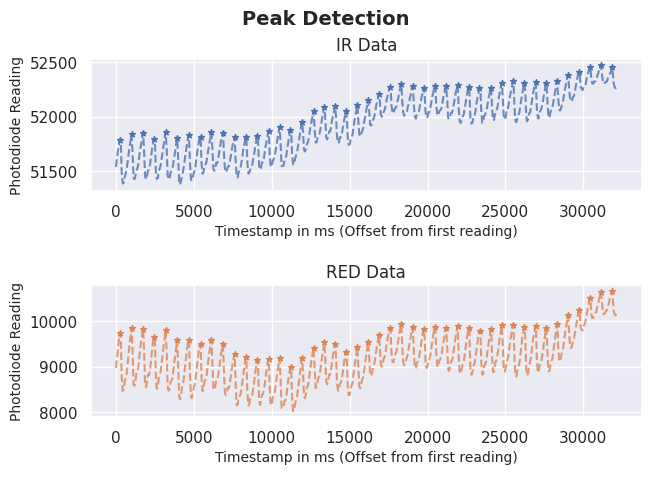

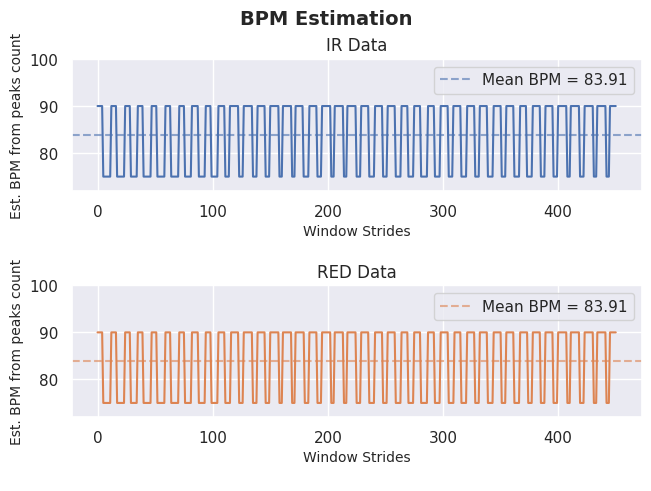

In [2]:
# Identify prominent peaks
idx_ir_peaks, _ = find_peaks(ppg_data[:, ID_IR], prominence=20)
idx_red_peaks, _ = find_peaks(ppg_data[:, ID_RED], prominence=20)

# Take difference of indices to analyse peak correlation
idx_diff = np.abs(idx_ir_peaks - idx_red_peaks)

# Ideally when the signal peaks match perfectly, difference vector will be
# zero. Sparsity of a vector is the percentage of non-zero elements.
# Sparsity along with the range of absolute difference will together help us analyse correlation.
idx_diff_range = (idx_diff.min(), idx_diff.max())
idx_diff_sparsity = 1.0 - np.count_nonzero(idx_diff) / idx_diff.size

print(f"Peak indices diff. range: {idx_diff_range}")
print(f"Peak indices diff. sparsity: {idx_diff_sparsity:0.2f}")

plt.rcParams["figure.constrained_layout.use"] = True

plt.subplot(2, 1, 1)
plt.plot(ppg_data[:, ID_TIME], ppg_data[:, ID_IR], "--", color=cmap[0], alpha=0.8)
plt.scatter(
    ppg_data[idx_ir_peaks, ID_TIME],
    ppg_data[idx_ir_peaks, ID_IR],
    color=cmap[0],
    s=18,
    marker="*",
)
plt.xlabel("Timestamp in ms (Offset from first reading)\n", fontsize="small")
plt.ylabel("Photodiode Reading", fontsize="small")
plt.title("IR Data")

plt.subplot(2, 1, 2)
plt.plot(ppg_data[:, ID_TIME], ppg_data[:, ID_RED], "--", color=cmap[1], alpha=0.8)
plt.scatter(
    ppg_data[idx_red_peaks, ID_TIME],
    ppg_data[idx_red_peaks, ID_RED],
    color=cmap[1],
    s=18,
    marker="*",
)
plt.xlabel("Timestamp in ms (Offset from first reading)\n", fontsize="small")
plt.ylabel("Photodiode Reading", fontsize="small")
plt.title("RED Data")

plt.suptitle("Peak Detection", fontsize=14, fontweight="bold")
plt.show()

# To count number of peaks efficienty, we create two boolean arrays of same length as the
# raw signals (IR and RED). This array stores 1 when the corresponding index in the signal is a peak
# and 0 otherwise. Convolving this array with a kernel of all ones [1,1,1,...] will return the count
# of peaks in the time interval corresponding to the size of the kernel. Further, to calculate BPM,
# we just need to multiply this peak count with a factor of 60/window_duration which we multiply
# in the kernel itself for efficiency.
ir_peaks = np.zeros_like(ppg_data[:, ID_IR])
ir_peaks[idx_ir_peaks] = 1
red_peaks = np.zeros_like(ppg_data[:, ID_RED])
red_peaks[idx_red_peaks] = 1

# Generate kernel
WINDOW_DURATION_SECS = 4
window_len = int(WINDOW_DURATION_SECS * sample_rate_est)
kernel = (60 / WINDOW_DURATION_SECS) * np.ones((window_len,))

# In "valid" mode the convolution product is only given for points where the signals overlap
# completely. We are not interested in boundary effects.
ir_bpm = np.convolve(ir_peaks, kernel, mode="valid")
red_bpm = np.convolve(red_peaks, kernel, mode="valid")

plt.rcParams["figure.constrained_layout.use"] = True

plt.subplot(2, 1, 1)
plt.plot(ir_bpm, color=cmap[0])
plt.axhline(
    y=ir_bpm.mean(),
    ls="--",
    color=cmap[0],
    label=f"Mean BPM = {ir_bpm.mean():0.2f}",
    alpha=0.6,
)
plt.xlabel("Window Strides\n", fontsize="small")
plt.ylabel("Est. BPM from peaks count", fontsize="small")
plt.ylim((72, 100))
plt.legend()
plt.title("IR Data")

plt.subplot(2, 1, 2)
plt.plot(red_bpm, color=cmap[1])
plt.axhline(
    y=red_bpm.mean(),
    ls="--",
    color=cmap[1],
    label=f"Mean BPM = {red_bpm.mean():0.2f}",
    alpha=0.6,
)
plt.xlabel("Window Strides\n", fontsize="small")
plt.ylabel("Est. BPM from peaks count", fontsize="small")
plt.ylim((72, 100))
plt.legend()
plt.title("RED Data")

plt.suptitle("BPM Estimation", fontsize=14, fontweight="bold")
plt.show()


##### Observations Task 2

Q. *Plot the peak locations for the signals. Do the peak indices between the two signals match?*
- **Approach**
    - Peak indices were calculated using `scipy.signal.find_peaks`
    - To analyse peak correlation, analysing the sparsity and range of values in the difference vector ($peaks_{IR} - peaks_{RED}$) is an easy and reliable approach.
- **Observations**
    - Sparsity of difference vector = **96%**, meaning the difference in indices is zero 96% of the time.
    - At the locations of mismatch, the indices differ atmost by 1.
- **Inference**
    - There is a high peak correlation between the two signals.
    - Peak indices in the two signals match almost entirely.

Q. *Calculate the BPM using a sliding window of size 4 seconds. Plot BPM versus time.*
- **Approach**
    - To efficiently count the peaks in a sliding window approach, we can generate a binary array (same dimensions as the signal) storing 1 when the corresponding signal value is a prominent peak and 0 otherwise.
    - Convoling this array using a kernel of 1s ([1,1,1,...]) with appropriate window size will return the number of peaks in the input signal for each stride.
- **Observations**
    - Due to the sliding window approach the number of peaks within a window tend to oscillate between two values.
    - This is because the window stride is not in sync with the signal time period.
    - The running average of the BPM values computed in the sliding window approach gives a better estimate of BPM.
    - The pulse rate is estimated to be **83.91 BPM (~84 BPM)**.

<div class="alert alert-block alert-warning">
<b>Note:</b> For Tasks 3, 4 and 5 use only the RED channel data (no need to use IR data).
</div>


### Task 3: Frequency domain analysis [2 + 20 + 10 = 32 points] <a id='task3'></a>

1. What is the maximum frequency value that can be tracked in the provided signals?
2. Implement a function realizing the **coiling machine analogy** as discussed in class with detailed comments.
3. Run the coiling machine for `N = 32`, `64`, `128`, `256`, and `512` samples. Report the BPM values obtained in these five settings in a table. Validate the output with the library function `numpy.fft.fft`. Show the heatmaps as a 2x5 _subplot_. Label them properly. The top row corresponds to your function, while the bottom row corresponds to the numpy FFT implementation.


N =  32,	Resolution = 0.50 Hz,	Est. BPM = 90.38 (1.51 Hz)
N =  64,	Resolution = 0.25 Hz,	Est. BPM = 75.32 (1.26 Hz)
N = 128,	Resolution = 0.13 Hz,	Est. BPM = 82.85 (1.38 Hz)
N = 256,	Resolution = 0.06 Hz,	Est. BPM = 82.85 (1.38 Hz)
N = 512,	Resolution = 0.03 Hz,	Est. BPM = 84.73 (1.41 Hz)


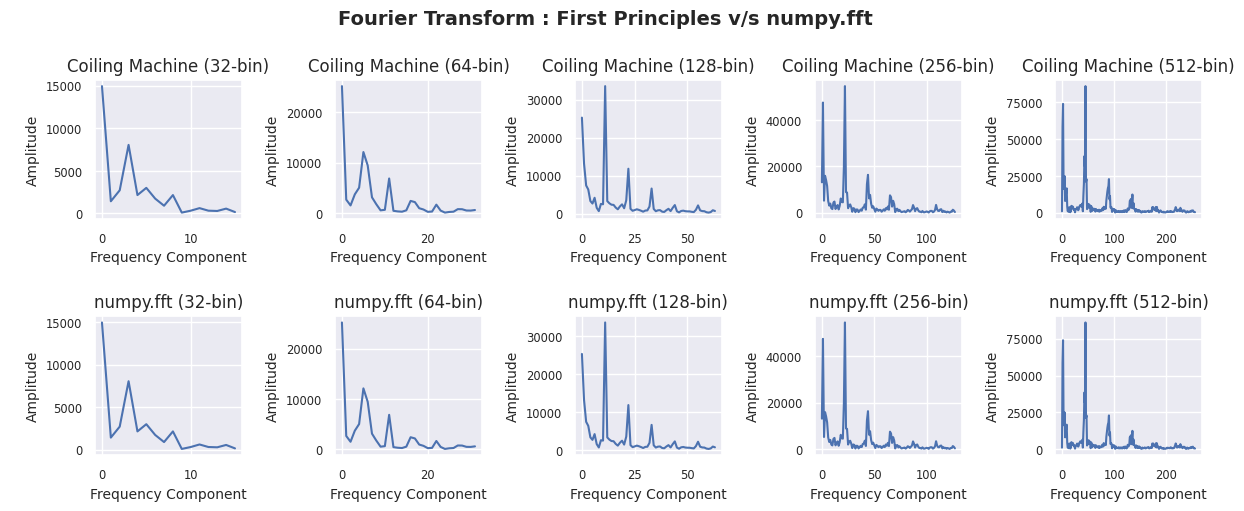

In [3]:
def coiling_machine(arr, N):
    """Implements coiling machine analogy of DFT."""

    # Sanitise inputs
    if N < arr.size:
        arr = arr[:N]
    elif N > arr.size:
        N = arr.size

    # Initialise frequency components as a complex array (This will hold the centre of mass (scaled)
    # of the final wrapped structure in coiling machine, in complex form)
    fcomp = 1j * np.zeros((N,))

    for i in range(N):
        # For each frequency component, calculate the angle between two consecutive
        # samples in the coiling machine
        th = 2 * np.pi * i / N
        # Rotate the each sample anti-clockwise by this angle and compute the sum.
        # This is the centre of mass of the structure scaled by a factor of the number of samples.
        # This scaling is necessary to observe the improvement of SNR as more and more samples
        # are considered for wrapping around the machine.
        fcomp[i] = np.sum(arr * np.exp(-1j * th * np.indices((N,))))

    # Ignore the negative frequencies (mirror image) and return the amplitude (dist. from origin) of the complex numbers.
    return np.abs(fcomp[: N // 2])


def numpy_fft(arr, N):
    """Wrapper around numpy.fft.fft, Slices negative frequencies (mirror image) from DFT output."""

    fcomp = np.fft.fft(arr, N)
    # Ignore the negative frequencies (mirror image) and return the amplitude (dist. from origin) of the complex numbers.
    return np.abs(fcomp[: N // 2])


def estimate_bpm(dft, bins, sample_rate):
    """Estimate BPM from Discrete Fourier Transform."""

    resolution = sample_rate / bins
    # Compute the frequency component corresponding to the most prominent peak
    fcomp_peaks, _ = find_peaks(dft)
    fcomp_mx_peak = fcomp_peaks[np.argmax(dft[fcomp_peaks])]
    # Convert component frequency to BPM
    bpm = 60 * resolution * fcomp_mx_peak
    return bpm, resolution


red_data = ppg_data[:, ID_RED]
# Detrend the signal to remove linear and DC components.
# If we analyse the input signal (Task 1), it has a tendency to shift upwards which introduces
# low frequency components into the DFT later. This effect interfers with the principal frequency
# component detection as more and more samples are considered (512-bin FFT). Detrending gets rid
# of undesired linear components from the input signal and suppresses this effect.
red_data = detrend(red_data)

n_vals = (32, 64, 128, 256, 512)  # Number of samples for each iteration

# DFT using coiling machine
cm_out = map(lambda n: coiling_machine(red_data, n), n_vals)
# DFT using numpy.fft.fft
np_out = map(lambda n: numpy_fft(red_data, n), n_vals)

plt.rcParams["figure.constrained_layout.use"] = True
plt.gcf().set_size_inches(12, 5)

for i, components in enumerate(cm_out):
    bpm_est, resolution = estimate_bpm(components, n_vals[i], sample_rate_est)

    print(
        f"N = {n_vals[i]:3},\tResolution = {resolution:0.2f} Hz,\tEst. BPM = {bpm_est:0.2f} ({bpm_est/60:0.2f} Hz)"
    )
    plt.subplot(2, 5, i + 1)
    plt.plot(components)
    plt.xlabel("Frequency Component", fontsize="small")
    plt.ylabel("\nAmplitude", fontsize="small")
    plt.xticks(fontsize="x-small")
    plt.yticks(fontsize="x-small")
    plt.title(f"\nCoiling Machine ({n_vals[i]}-bin)")

for i, components in enumerate(np_out):
    plt.subplot(2, 5, i + 1 + 5)
    plt.plot(components)
    plt.xlabel("Frequency Component", fontsize="small")
    plt.ylabel("\nAmplitude", fontsize="small")
    plt.xticks(fontsize="x-small")
    plt.yticks(fontsize="x-small")
    plt.title(f"\nnumpy.fft ({n_vals[i]}-bin)")

plt.suptitle(
    "Fourier Transform : First Principles v/s numpy.fft", fontsize=14, fontweight="bold"
)
plt.show()


##### Observations Task 3

- **Approach**
    - As a preprocessing step, detrending is applied to the red channel data. This removes linear trends in the data which was observed to introduce low frequency noise component into the signal. 
    - Detrending also keeps the DC component (corresponding to frequency component 0) of the signal to a minimum. This ensures that there no absurd peaks at $f = 0$ in the frequency domain plots.
    - The wrapping of the signal in the implementation of coiling machine is carried out using complex numbers for easy and efficient calculation.
    - Negative DFT frequencies are removed from the plots since these are mirror images of the corresponding positive frequencies.
- **Observations**

Sampling rate, S = ~**16 Hz**.

Maximum trackable frequency = S/2 = ~**8 Hz** (Nyquist).

| N   | DFT Resolution (Hz) | Prominent Frequency (Hz) | Estimated BPM   |
| --- | ------------------- | ------------------------ | --------------- |
| 32  | 0.50                | 1.51                     | 90.38           |
| 64  | 0.25                | 1.26                     | 75.32           |
| 128 | 0.13                | 1.38                     | 82.85           |
| 256 | 0.06                | 1.38                     | 82.85           |
| 512 | 0.03                | 1.41                     | 84.73           |

- **Inference**
    - The resolution of frequency components in DFT increases with the number of samples.
    - SNR in the frequency domain increases as more samples are considered leading to more prominent and distinguishable peaks.
    - The BPM values estimated from the frequency component analysis are more or less in agreement with prior estimations by peak counting.
    - DFT of the signal computed using the coiling machine analogy is in agreement with the DFT output given by `numpy.fft.fft`

### Task 4: Spectrograms [10 + 10 = 20 points] <a id='task4'></a>

1. Plot the time-frequency spectrogram of the above data using your coiling machine function, taking a moving average window of size 2, 8, and 16 seconds. Show the heatmaps as a 1x3 _subplot_. Label them properly.
2. Add gaussian noise to the samples with a mean of 200 and a standard deviation of 50. Run the above analysis (4.1) again. Validate any improvement brought in by the 16 second window over the 2 or 8 second ones.


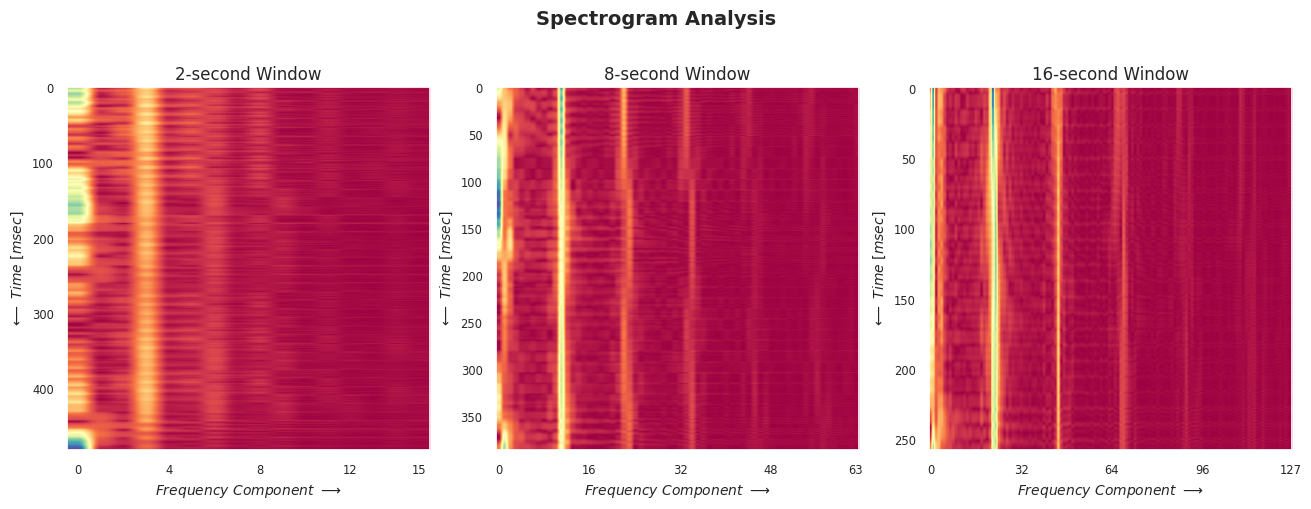

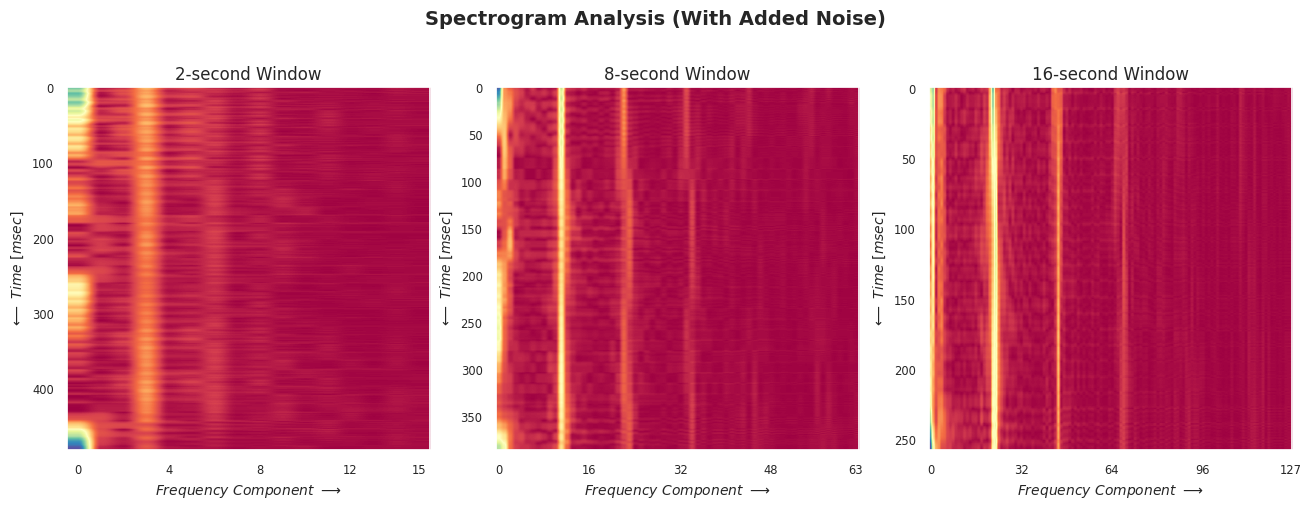

In [4]:
plt.gcf().set_size_inches(13, 5)
for i, window_duration in enumerate((2, 8, 16)):
    window_len = int(sample_rate_est * window_duration)

    # Generate windows from signal data efficiently
    # 
    # sliding_window_view([1, 2, 3, 4, 5], 3) = [[1, 2, 3],
    #                                            [2, 3, 4],
    #                                            [3, 4, 5]]
    #
    window_views = sliding_window_view(red_data, window_len)

    # Run coiling machine for each window
    # output size: (n_windows, n_frequency_components)
    spectrogram = np.apply_along_axis(
        lambda wnd: coiling_machine(wnd, wnd.size), axis=1, arr=window_views
    )
    plt.subplot(1, 3, i + 1)
    plt.grid(False)
    n_windows, n_fcomps = spectrogram.shape
    plt.imshow(spectrogram, aspect=n_fcomps / n_windows, cmap="Spectral")
    xticks = np.append(np.arange(0, n_fcomps, window_duration * 2), n_fcomps - 1)
    plt.xticks(xticks, fontsize="x-small")
    plt.yticks(fontsize="x-small")
    plt.xlabel(r"$Frequency\ Component\ \longrightarrow$", fontsize="small")
    plt.ylabel(r"$\longleftarrow\ Time\ [msec]$", fontsize="small")
    plt.title(f"{window_duration}-second Window")

plt.suptitle("Spectrogram Analysis", fontsize=14, fontweight="bold")
plt.show()

# Add gaussian noise with mean = 200 and std.dev = 50
red_data_noisy = red_data + np.random.normal(200, 50, red_data.size)

# Plot spectograms for noisy data (logic same as above)
plt.gcf().set_size_inches(13, 5)
for i, window_duration in enumerate((2, 8, 16)):
    window_len = int(sample_rate_est * window_duration)

    window_views = sliding_window_view(red_data_noisy, window_len)

    spectrogram = np.apply_along_axis(
        lambda wnd: coiling_machine(wnd, wnd.size), axis=1, arr=window_views
    )
    plt.subplot(1, 3, i + 1)
    plt.grid(False)
    n_windows, n_fcomps = spectrogram.shape
    plt.imshow(spectrogram, aspect=n_fcomps / n_windows, cmap="Spectral")
    xticks = np.append(np.arange(0, n_fcomps, window_duration * 2), n_fcomps - 1)
    plt.xticks(xticks, fontsize="x-small")
    plt.yticks(fontsize="x-small")
    plt.xlabel(r"$Frequency\ Component\ \longrightarrow$", fontsize="small")
    plt.ylabel(r"$\longleftarrow\ Time\ [msec]$", fontsize="small")
    plt.title(f"{window_duration}-second Window")

plt.suptitle("Spectrogram Analysis (With Added Noise)", fontsize=14, fontweight="bold")
plt.show()

##### Observations Task 4

Q. *Plot the time-frequency spectrogram of the above data using your coiling machine function, taking a moving average window of size 2, 8, and 16 seconds. Show the heatmaps as a 1x3 _subplot_. Label them properly.*
- **Approach**
    - For each window duration 2, 8 and 16 seconds, we generate sliding window views from the input signal with unit stride. DFT is carried out in each of the windows using the coiling machine implemented prior, giving us the final spectrogram matrix.
    - Matrix is then visualised with appropriate color map.
    - The library functions are used to the extent possibe for fast and efficient calculation involving large vectors and matrices.
- **Observations**
    - The prominent frequency components are more or less constant as time progresses.
    - The relative prominence of the high energy frequencies are clearly distinguishable as the window size increases.
- **Inference**
    - The signal is clearly composed of certain principal frequency components.
    - SNR in frequency domain increases as more and more samples are considered, making the principal frequencies distinguishable from the rest.

Q. *Add gaussian noise to the samples with a mean of 200 and a standard deviation of 50. Run the above analysis (4.1) again. Validate any improvement brought in by the 16 second window over the 2 or 8 second ones.*
- **Approach**
    - Noise (Gaussian) is artifically added to the signal with mean = 200 and std. dev = 50. 
    - Spectrogram analysis is carried out on the noisy signal with steps same as above.
- **Observations**
    - The intensity of the principal frequency components have reduced (visible by slight fading in spectrogram) when comparing the original signal spectrogram with that of the noisy signal.
    - This reduction in intensity is further less as we move from window duration 2 to 8 and finally to 16 seconds.
- **Inference**
    - Noise in signals adversely affects the relative prominence of principal frequencies (peaks in DFT) in the underlying original signal.
    - However this effect is less dominant when using more samples (larger DFT window size) as it distinguishes the peaks more. This is because SNR in frequency domain
    increases with more and more samples
    - Thus the 16s-window DFT has a clear advantage over the 2s and 8s window DFTs as it is the least affected by the noise addition amongst the three.

### Task 5: Quantization of sensor data [5 + 15 + 8 = 28 points] <a id='task5'></a>

Assume that a 16-bit ADC was used in the sensor that maps the range 0 to 5 volts.

1. How many bits would have sufficed at the minimum without losing the accuracy of the signal?
2. Now start lowering the number of bits (of course virtually), one at a time, up to a minimum of 2 bits, and represent the data with the relevant number of bits. Plot detected BPM versus the number of ADC bits. To detect BPM, directly use a 512-bin FFT on all the samples.
3. Does the plot in 5.2 change if we consider the noisy samples as produced in 4.2?


RED values range: (8025, 10659)
Min. number of bits required to accurately represent signal: 12


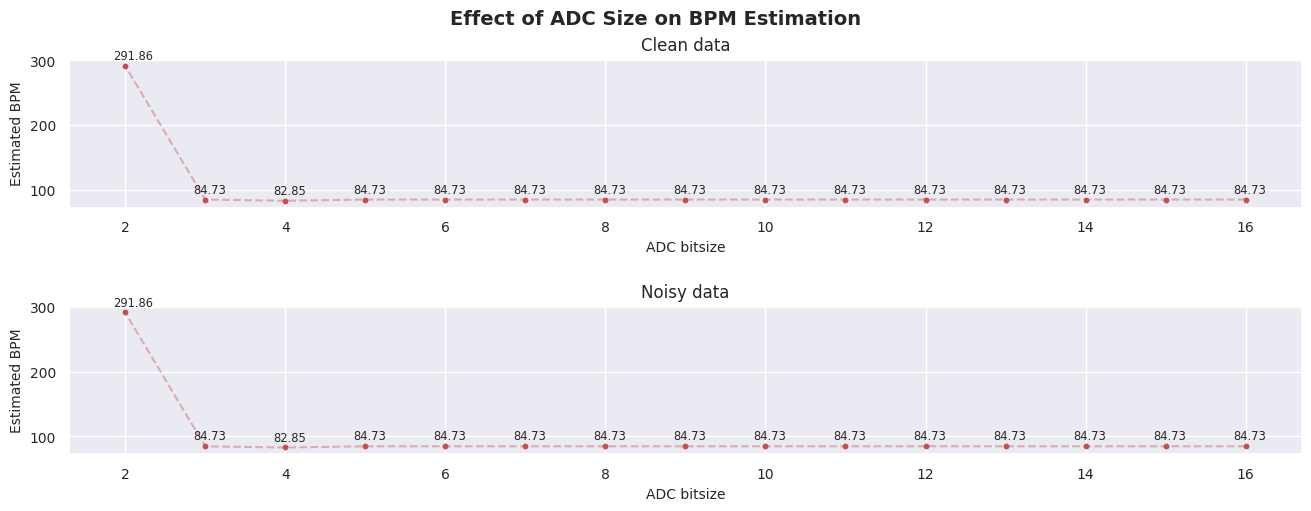

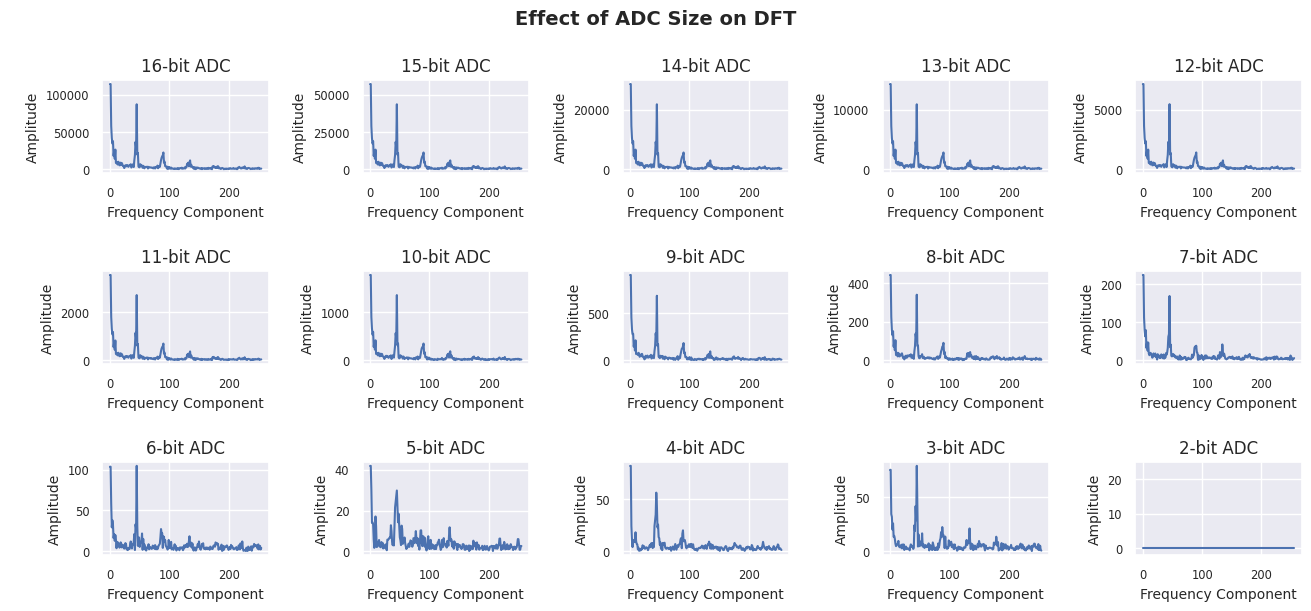

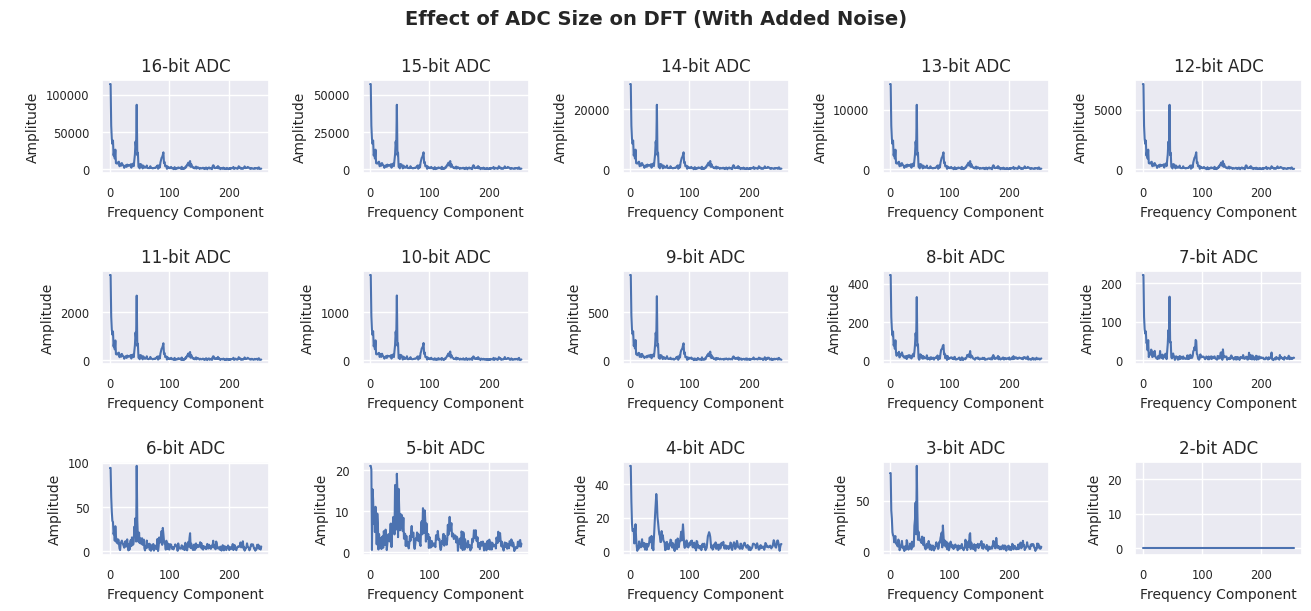

In [5]:
red_data = ppg_data[:, ID_RED]  # Use raw data to avoid effects due to detrending
red_mn, red_mx = red_data.min(), red_data.max()
mn_bits = np.ceil(np.log2(red_mx - red_mn))
print(f"RED values range: {(int(red_mn), int(red_mx))}")
print(f"Min. number of bits required to accurately represent signal: {int(mn_bits)}")


def ADC_sim(analog_data, bits, Vmin=0, Vmax=5):
    """Simulate ADC functionality."""

    # Generate voltage values corresponding to the 2^k levels, where k is ADC bitsize
    adc_levels = np.linspace(Vmin, Vmax, 1 << bits)
    # Simple binary search in the level array, wil1 << bits)l return the index of the first value
    # in array greater than or equal to the analog input
    return np.searchsorted(adc_levels, analog_data)


# Add noise to data
red_data_noisy = red_data + np.random.normal(200, 50, red_data.size)

# Generate actual analog signal from input data
analog_clean, analog_noisy = map(
    lambda v: 5 * v / ((1 << 16) - 1), (red_data, red_data_noisy)
)

DFT_BINS = 512
bitsizes = np.arange(16, 1, -1)
bpm_estimates = {"clean": [], "noisy": []}
dfts = {"clean": [], "noisy": []}

for bitsize in bitsizes:
    # Run virtual ADC on analog data
    adc_out_clean, adc_out_noisy = map(
        lambda analog: ADC_sim(analog, bitsize), (analog_clean, analog_noisy)
    )
    # Run DFT on ADC output
    dft_clean, dft_noisy = map(
        lambda adc_out: coiling_machine(adc_out, DFT_BINS), (adc_out_clean, adc_out_noisy)
    )

    # Suppress undesired DC component in DFT (frequency component = 0)
    dft_clean[0] = dft_clean[1]
    dft_noisy[0] = dft_noisy[1]

    # Save DFT for visualisation
    dfts["clean"].append(dft_clean)
    dfts["noisy"].append(dft_noisy)

    # Estimate BPM
    bpm_estimates["clean"].append(estimate_bpm(dft_clean, DFT_BINS, sample_rate_est)[0])
    bpm_estimates["noisy"].append(estimate_bpm(dft_noisy, DFT_BINS, sample_rate_est)[0])


bpm_estimates["clean"] = np.array(bpm_estimates["clean"])
bpm_estimates["noisy"] = np.array(bpm_estimates["noisy"])

plt.rcParams["figure.constrained_layout.use"] = True
plt.gcf().set_size_inches(13, 5)

plt.subplot(2, 1, 1)
plt.scatter(bitsizes, bpm_estimates["clean"], s=10, color=cmap[3])
plt.plot(bitsizes, bpm_estimates["clean"], "--", alpha=0.4, color=cmap[3])
plt.xticks(fontsize="small")
plt.yticks(fontsize="small")
plt.xlabel("ADC bitsize", fontsize="small")
plt.ylabel("Estimated BPM", fontsize="small")
for x, y in zip(bitsizes, bpm_estimates["clean"]):
    plt.text(x-0.15, y + 10, str(round(y, 2)), fontsize="x-small")
plt.title("Clean data")

plt.subplot(2, 1, 2)
plt.scatter(bitsizes, bpm_estimates["noisy"], s=10, color=cmap[3])
plt.plot(bitsizes, bpm_estimates["noisy"], "--", alpha=0.4, color=cmap[3])
plt.xticks(fontsize="small")
plt.yticks(fontsize="small")
plt.xlabel("ADC bitsize", fontsize="small")
plt.ylabel("Estimated BPM", fontsize="small")
for x, y in zip(bitsizes, bpm_estimates["noisy"]):
    plt.text(x-0.15, y + 10, str(round(y, 2)), fontsize="x-small")
plt.title("\nNoisy data")

plt.suptitle("Effect of ADC Size on BPM Estimation", fontsize=14, fontweight="bold")
plt.show()

plt.rcParams["figure.constrained_layout.use"] = True
plt.gcf().set_size_inches(13, 6)

for i, (bitsize, dft) in enumerate(zip(bitsizes, dfts["clean"])):
    plt.subplot(3, 5, i+1)
    plt.plot(dft)
    plt.xlabel("Frequency Component", fontsize="small")
    plt.ylabel("\nAmplitude", fontsize="small")
    if bitsize == 2:
        plt.ylim((-2, 25))
    plt.xticks(fontsize="x-small")
    plt.yticks(fontsize="x-small")
    plt.title(f"\n{bitsize}-bit ADC")

plt.suptitle("Effect of ADC Size on DFT", fontsize=14, fontweight="bold")
plt.show()

plt.rcParams["figure.constrained_layout.use"] = True
plt.gcf().set_size_inches(13, 6)

for i, (bitsize, dft) in enumerate(zip(bitsizes, dfts["noisy"])):
    plt.subplot(3, 5, i+1)
    plt.plot(dft)
    plt.xlabel("Frequency Component", fontsize="small")
    plt.ylabel("\nAmplitude", fontsize="small")
    if bitsize == 2:
        plt.ylim((-2, 25))
    plt.xticks(fontsize="x-small")
    plt.yticks(fontsize="x-small")
    plt.title(f"\n{bitsize}-bit ADC")

plt.suptitle("Effect of ADC Size on DFT (With Added Noise)", fontsize=14, fontweight="bold")
plt.show()


##### Observations Task 5

Q. *How many bits would have sufficed at the minimum without losing the accuracy of the signal?*
- RED values in the input data lie in the range [8025, 10659]
- Values in this range has a one-to-one correspondence with values in [0, 10659-8025] = [0, 2634]
- Minimum number of bits required to represent these values = ceil(log2(2634)) = 12 bits. 
- This can be practically accomplished by using an ADC of 12 bits and choosing the appropriate Vmin and Vmax.

Q. *Now start lowering the number of bits (of course virtually), one at a time, up to a minimum of 2 bits, and represent the data with the relevant number of bits. Plot detected BPM versus the number of ADC bits. To detect BPM, directly use a 512-bin FFT on all the samples.*
- **Approach**
    - Convert given data (16-bit ADC) to corresponding analog voltage values.
    - Simulate ADC functionality using a simple binary search for each bitsize
    - Run DFT (coiling machine) on the virtual ADC output, detect prominent peak and convert the corresponding frequency to BPM.
- **Observations**
    - The predictions are generally consistent even though the ADC size is varying, except a small deviation for a 4-bit ADC and a completely off prediction for a 2 bit ADC.
    - The reason the effect of ADC size is not visible for the given data is that the oscillations in given data due to pulse really stand out and is captured relatively easily under DFT. However if we were to analyse a signal with multiple frequencies of interest that are close to one another then the effects of ADC size will be more evident.
    - Higher frequency harmonics are affected by ADC size much more than lower frequencies.
    - When it comes to 2-bit ADC the ADC output is a pure DC signal (original signal lies between 0.5 and 1) and the DFT is rendered useless.
- **Inference**
    - For the given data, the principal frequencies of interest really stand out from the rest low size ADCs are capable of capturing the component. How this cannot be generalised.

Q. *Does the plot in 5.2 change if we consider the noisy samples as produced in 4.2?*
- **Approach**
    - Noise is artificially introduced into the signal (Gaussian, mean=200 and std. dev=50) and the analysis is carried out as in 5.1
- **Observations**
    - There is little to no change in the BPM prediction plot when noise is added. This is because the peaks of interest in DFT really stand out from the rest and the amount of noise added isn't enough to affect the peaks themselves altogether.
    - The DFTs of lower size ADCs are more affected by the noise addition compared to higher size ADCs. But due to the prominence of the peaks this effect does not intefere with the BPM estimation.
- **Inference**
    - Due to large energy contribution from the pulse frequencies, the noise addition has little to no effect on the BPM predictions.
    - The effect of noise becomes more and more evident for low bit ADCs and the resolution reduces with lower bits and the noise levels and significant enough to alter the bits and thus the signal, this tampers with the fundamental frequency components.